# Linear Similarity 

This notebooks explores the linear similarity (dot product) across different timestamps from the same variable with a configuration of the variable that relates highly to heatwaves (in the same timestamp).

In [1]:
import pandas as pd

import os
import numpy as np
import sys
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from IndexDrivers import calculate_anomalies, Index

c:\Users\marti\Desktop\data\hw_extra


In [23]:
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_msl = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")

## Advection Configuration

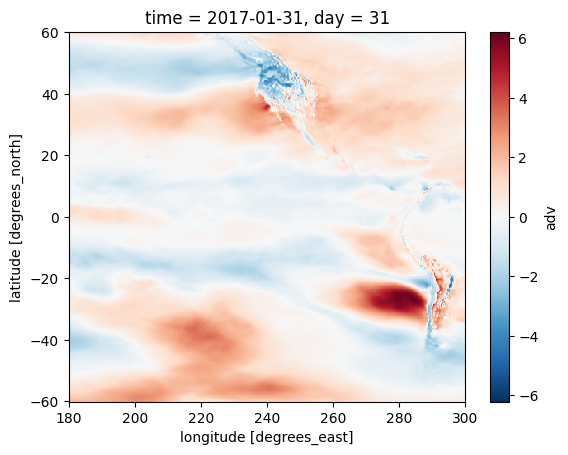

In [10]:
timestamp_hw = "2017-01"
data_850["adv"] = -1*data_850.u*data_850.t
data_850.adv.sel(time=timestamp_hw).plot()

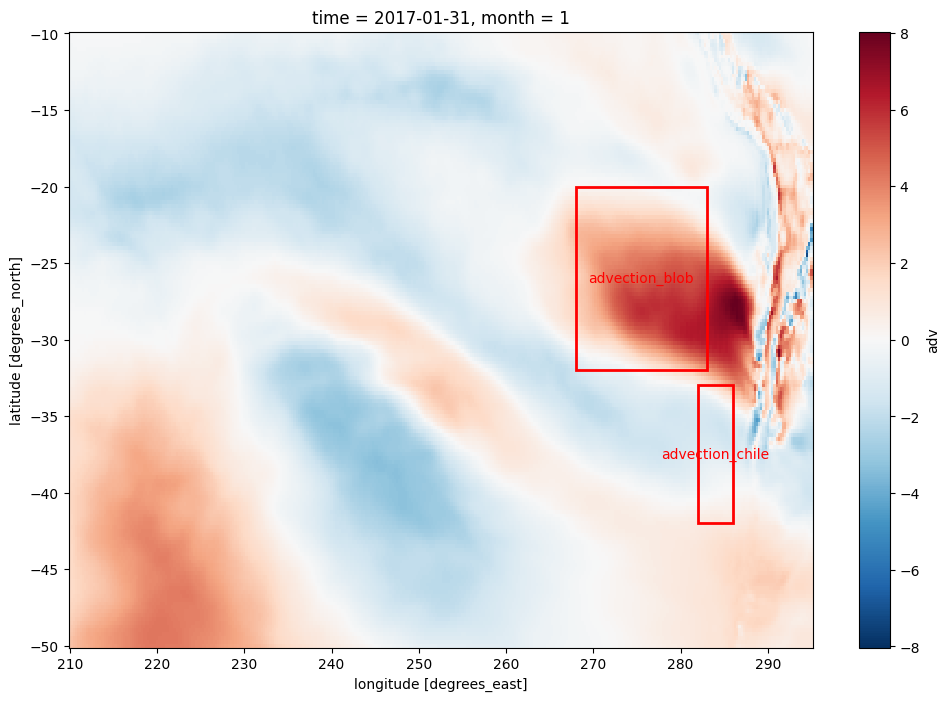

In [6]:
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_850.sel(longitude=slice(210,295), latitude=slice(-50,-10), time="2017-01").adv.plot(ax=ax)

for box_id, coords in boxes_chile_adv.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [7]:
box = boxes_chile_adv["advection_blob"]
adv_data = data_850.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))

In [8]:
b = adv_data.sel(time=timestamp_hw).adv.to_numpy().reshape(adv_data.sizes["latitude"], adv_data.sizes["longitude"])

In [9]:
vector_hw = b.flatten()

In [10]:
timeserie = []
for time_element in data_850.adv:
    box = boxes_chile_adv["advection_blob"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = b_data.to_numpy().reshape(b_data.sizes["latitude"], b_data.sizes["longitude"])
    timeserie.append(np.dot(vector_hw, element.flatten()))

In [11]:
high_hws_dates = ["2015-03-01", "2016-09-01", "1997-08-01", "2017-02-01", "2019-02-01", "2014-08-01"]
low_hws_date = ["2000-05-01", "1990-11-01", "2001-05-01", "1975-05-01"]

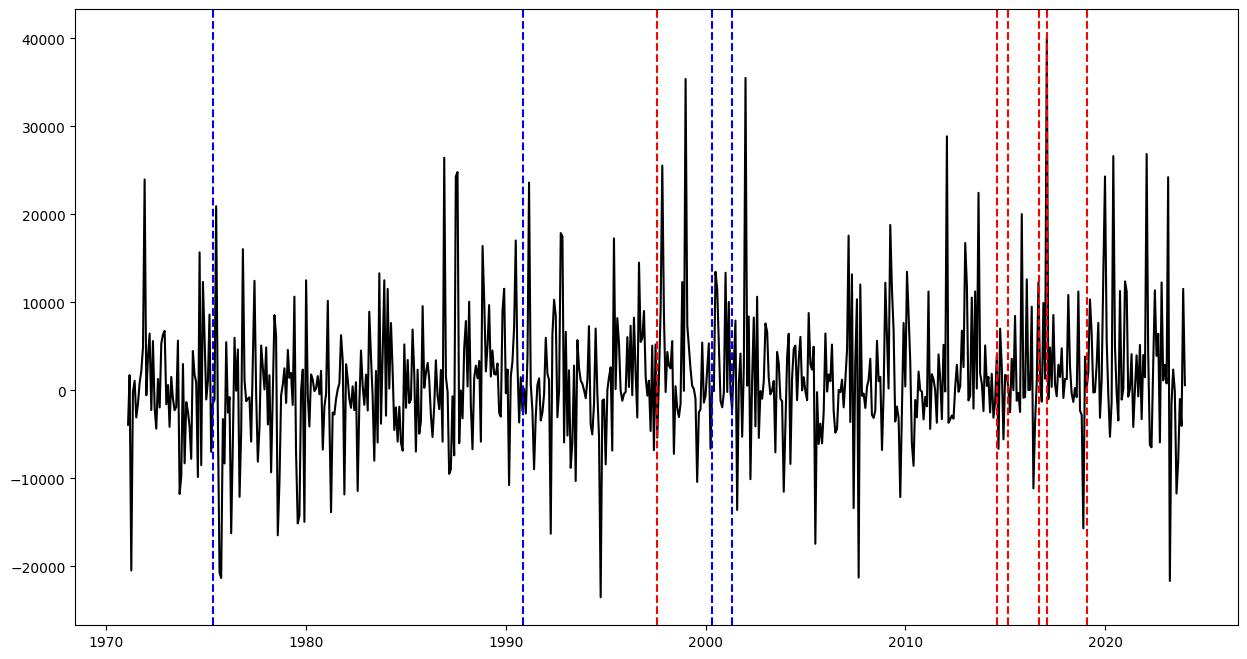

In [12]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_850.time, timeserie, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [13]:
df = data_850.time.to_dataframe()

In [14]:
df["adv_index"] = timeserie
df = df.drop(columns="time")
df = df[(df.index.year >= 1971) & (df.index.year <=2022)]
df.index = df.index.to_numpy().astype('datetime64[M]')  # Set the index as first day of the month
df.index.name = "Date"
df.drop(columns="month", inplace=True)
df

,adv_index
Date,
1971-01-01,-3914.062012
1971-02-01,1735.673584
1971-03-01,-20462.630859
1971-04-01,-208.754837
1971-05-01,1079.218872
...,...
2022-08-01,6430.470703
2022-09-01,-5918.168945
2022-10-01,12267.566406


In [15]:
adv_index = Index(data_850, ["ADV"], boxes_chile_adv["advection_blob"])
adv_index.set_index(df)

In [16]:
box = "|".join(str(x) for x in boxes_chile_adv["advection_blob"])
data = f"normalized,ADV,{box},1972-2024,1971-2022"
adv_index.index_df_to_parquet(data, "data/my_indices/","data/my_indices/metadata.csv")

Saved


'1797ec18'

In [17]:
def is_month(month, n):
    return month == n

In [18]:
timeserie_seasons = {}
normalized = data_850.adv
seasons = {i: normalized.sel(time=is_month(normalized['time.month'], i)) for i in range(1,13)}
for season, datas in seasons.items():
    timeserie = []
    for time_element in datas:
        box = boxes_chile_adv["advection_blob"]
        data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        element = data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"])
        timeserie.append(np.dot(vector_hw, element.flatten()))
    timeserie_seasons[season] = timeserie

In [19]:
hws_dates = {1: ['2016-01-01', '2017-01-01', '2013-01-01'],
             2: ['2020-02-01', '2005-02-01', '2008-02-01'],
             3: ['2015-03-01', '2009-03-01', '2012-03-01'],
             4: ['2009-04-01', '2017-04-01', '2015-04-01'],
             5: ['2020-05-01', '1998-05-01', '2023-05-01'],
             6: ['1987-06-01', '2015-06-01', '1991-06-01'],
             7: ['2023-07-01', '2006-07-01', '1996-07-01'],
             8: ['1997-08-01', '2001-08-01', '2003-08-01'],
             9: ['2016-09-01', '2008-09-01', '1996-09-01'],
             10: ['1983-10-01', '1989-10-01', '2014-10-01'],
             11: ['2019-11-01', '2008-11-01', '2022-11-01'],
             12: ['2021-12-01', '2001-12-01', '2013-12-01']}

non_hws_dates = {1: ['1975-01-01', '1974-01-01', '1981-01-01'],
             2: ['1975-02-01', '1972-02-01', '1986-02-01'],
             3: ['1975-03-01', '1972-03-01', '1985-03-01'],
             4: ['1975-04-01', '1973-04-01', '2000-04-01'],
             5: ['2000-05-01', '2001-05-01', '1975-05-01'],
             6: ['2007-06-01', '1975-06-01', '2011-06-01'],
             7: ['1971-07-01', '2017-07-01', '2007-07-01'],
             8: ['2017-08-01', '2007-08-01', '1971-08-01'],
             9: ['2007-09-01', '1987-09-01', '2017-09-01'],
             10: ['2023-10-01', '2017-10-01', '1987-10-01'],
             11: ['1990-11-01', '2017-11-01', '1973-11-01'],
             12: ['1975-12-01', '1973-12-01', '1974-12-01']}

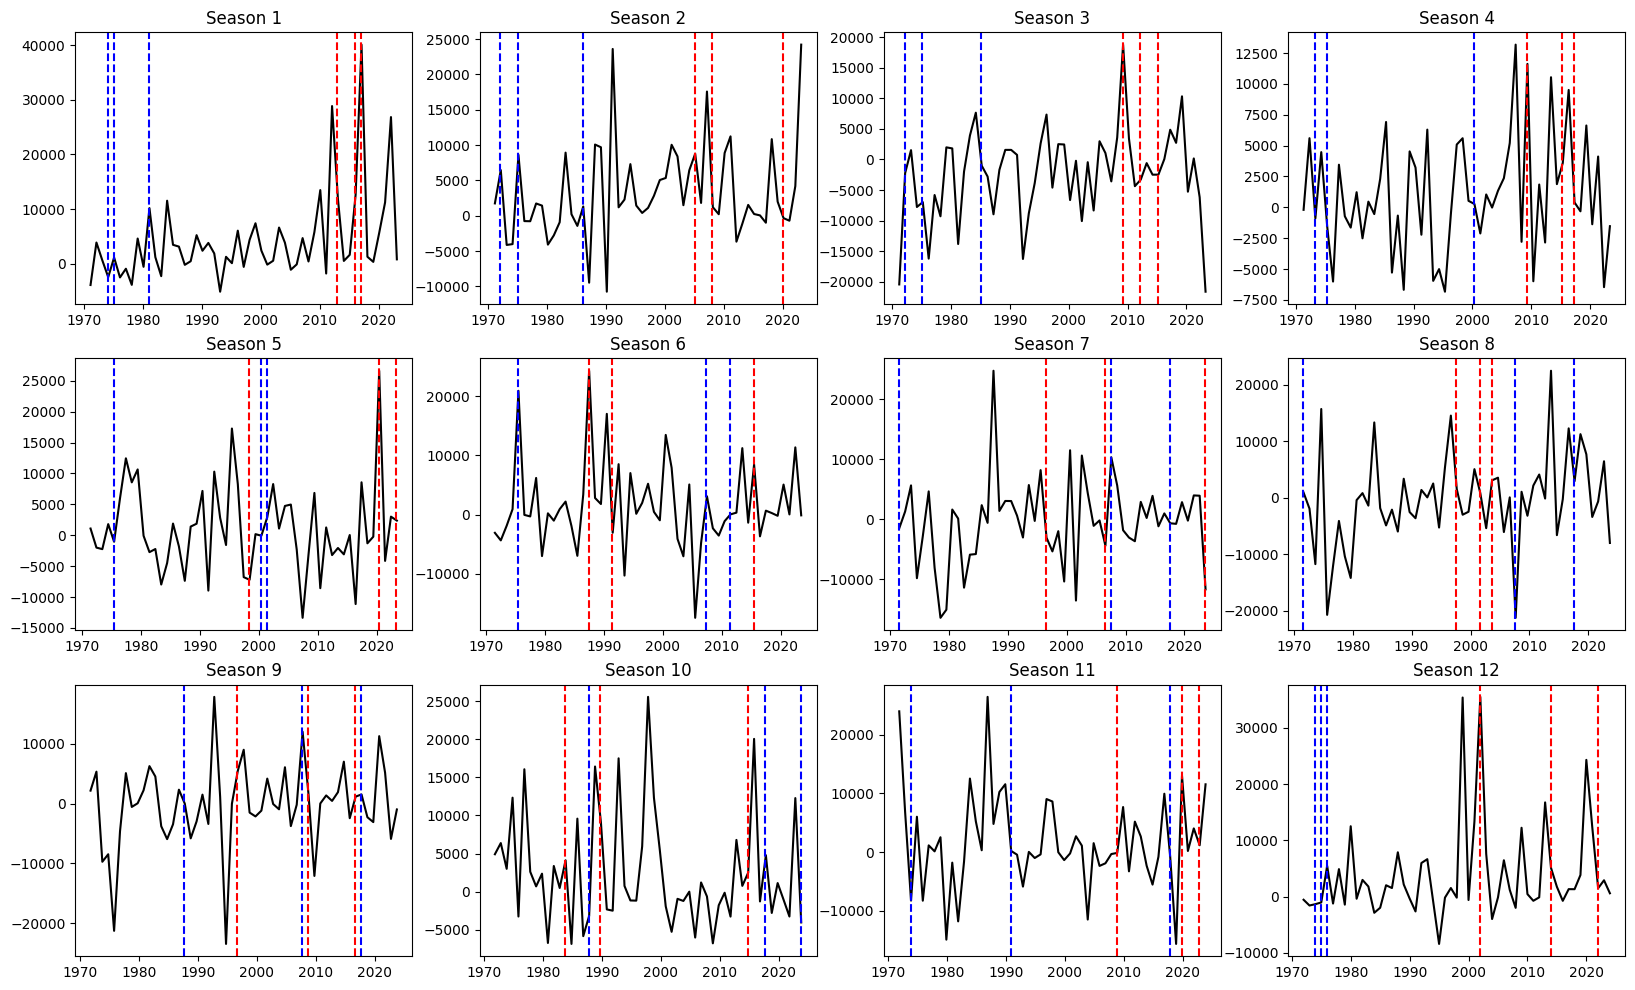

In [20]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, ts, c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')

In [21]:
box = boxes_chile_adv["advection_chile"]
adv_data = data_850.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))

In [22]:
b = adv_data.sel(time=timestamp_hw).adv.to_numpy().reshape(adv_data.sizes["latitude"], adv_data.sizes["longitude"])

In [23]:
vector_hw = b.flatten()

In [24]:
timeserie = []
for time_element in data_850.adv:
    box = boxes_chile_adv["advection_chile"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = b_data.to_numpy().reshape(b_data.sizes["latitude"], b_data.sizes["longitude"])
    timeserie.append(np.dot(vector_hw, element.flatten()))

In [25]:
high_hws_dates = ["2015-03-01", "2016-09-01", "1997-08-01", "2017-02-01", "2019-02-01", "2014-08-01"]
low_hws_date = ["2000-05-01", "1990-11-01", "2001-05-01", "1975-05-01"]

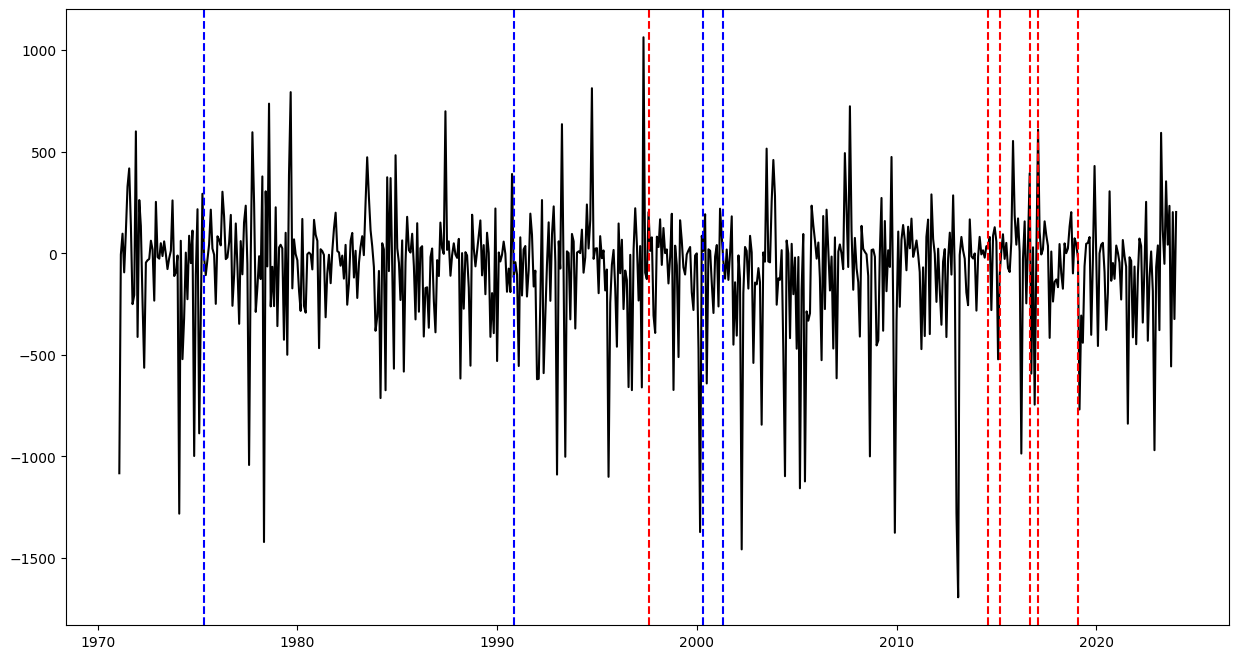

In [26]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_850.time, timeserie, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [27]:
df = data_850.time.to_dataframe()

In [28]:
df["adv_index"] = timeserie
df = df.drop(columns="time")
df = df[(df.index.year >= 1971) & (df.index.year <=2022)]
df.index = df.index.to_numpy().astype('datetime64[M]')  # Set the index as first day of the month
df.index.name = "Date"
df.drop(columns="month", inplace=True)
df

,adv_index
Date,
1971-01-01,-1082.447876
1971-02-01,-6.199306
1971-03-01,96.739761
1971-04-01,-93.638245
1971-05-01,107.931175
...,...
2022-08-01,-117.835052
2022-09-01,9.336004
2022-10-01,-187.084244


In [29]:
adv_index = Index(data_850, ["ADV"], boxes_chile_adv["advection_chile"])
adv_index.set_index(df)

In [30]:
box = "|".join(str(x) for x in boxes_chile_adv["advection_chile"])
data = f"normalized,ADV,{box},1972-2024,1971-2022"
adv_index.index_df_to_parquet(data, "data/my_indices/","data/my_indices/metadata.csv")

Saved


'26976a3c'

In [32]:
def is_month(month, n):
    return month == n

In [33]:
timeserie_seasons = {}
normalized = data_850.adv
seasons = {i: normalized.sel(time=is_month(normalized['time.month'], i)) for i in range(1,13)}
for season, datas in seasons.items():
    timeserie = []
    for time_element in datas:
        box = boxes_chile_adv["advection_chile"]
        data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        element = data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"])
        timeserie.append(np.dot(vector_hw, element.flatten()))
    timeserie_seasons[season] = timeserie

In [34]:
hws_dates = {1: ['2016-01-01', '2017-01-01', '2013-01-01'],
             2: ['2020-02-01', '2005-02-01', '2008-02-01'],
             3: ['2015-03-01', '2009-03-01', '2012-03-01'],
             4: ['2009-04-01', '2017-04-01', '2015-04-01'],
             5: ['2020-05-01', '1998-05-01', '2023-05-01'],
             6: ['1987-06-01', '2015-06-01', '1991-06-01'],
             7: ['2023-07-01', '2006-07-01', '1996-07-01'],
             8: ['1997-08-01', '2001-08-01', '2003-08-01'],
             9: ['2016-09-01', '2008-09-01', '1996-09-01'],
             10: ['1983-10-01', '1989-10-01', '2014-10-01'],
             11: ['2019-11-01', '2008-11-01', '2022-11-01'],
             12: ['2021-12-01', '2001-12-01', '2013-12-01']}

non_hws_dates = {1: ['1975-01-01', '1974-01-01', '1981-01-01'],
             2: ['1975-02-01', '1972-02-01', '1986-02-01'],
             3: ['1975-03-01', '1972-03-01', '1985-03-01'],
             4: ['1975-04-01', '1973-04-01', '2000-04-01'],
             5: ['2000-05-01', '2001-05-01', '1975-05-01'],
             6: ['2007-06-01', '1975-06-01', '2011-06-01'],
             7: ['1971-07-01', '2017-07-01', '2007-07-01'],
             8: ['2017-08-01', '2007-08-01', '1971-08-01'],
             9: ['2007-09-01', '1987-09-01', '2017-09-01'],
             10: ['2023-10-01', '2017-10-01', '1987-10-01'],
             11: ['1990-11-01', '2017-11-01', '1973-11-01'],
             12: ['1975-12-01', '1973-12-01', '1974-12-01']}

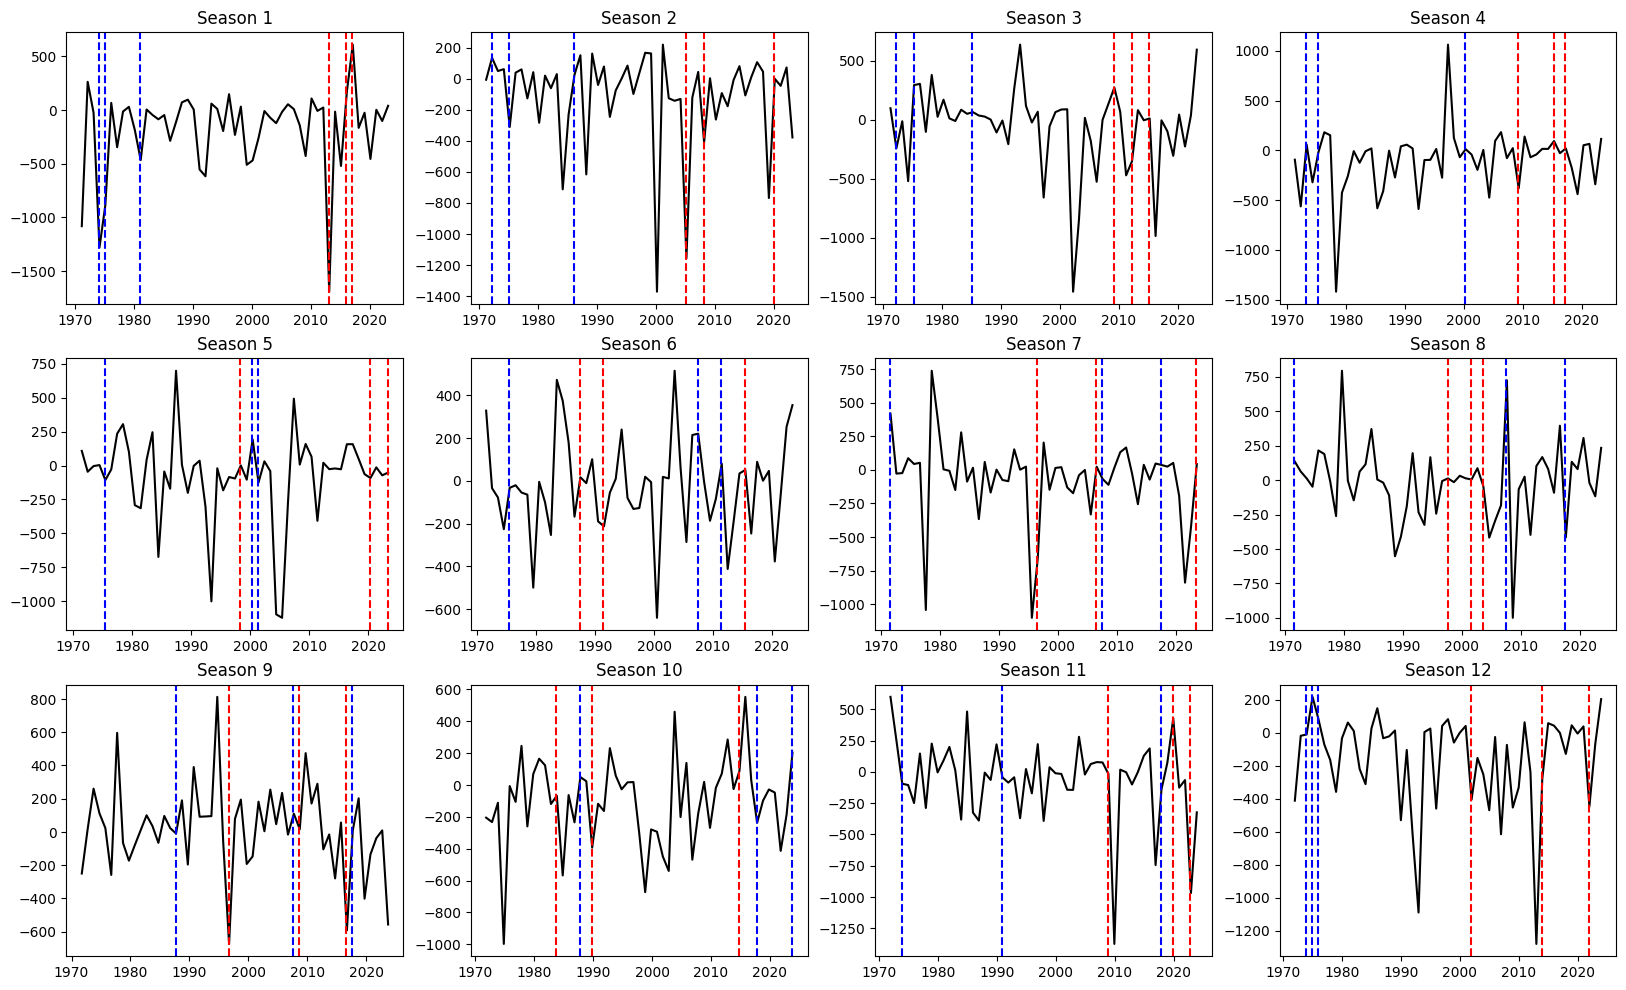

In [35]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, ts, c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')